# Uproot and Awkward Array tutorial

**July 6, 2021 at PyHEP**

<br><br><br><br><br>

## Z peak in PyROOT

Let's start with the most straightforward way to analyze HEP data in Python: "for" loops in PyROOT.

In [1]:
import time
import numpy as np
import ROOT

canvas = ROOT.TCanvas()

Welcome to JupyROOT 6.24/00


In [2]:
rootfile = ROOT.TFile.Open("data/HiggsZZ4mu.root")
roottree = rootfile.Get("Events")

In [3]:
starttime = time.time()

roothist = ROOT.TH1D("roothist", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # cuts are "if" statements
    if event.nMuon >= 2 and event.Muon_charge[0] + event.Muon_charge[1] == 0:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]

        # histograms are filled in the loop
        roothist.Fill(
            np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi)))
        )

pyroot_time = time.time() - starttime
print(f"total time: {pyroot_time} sec")

total time: 19.789664268493652 sec


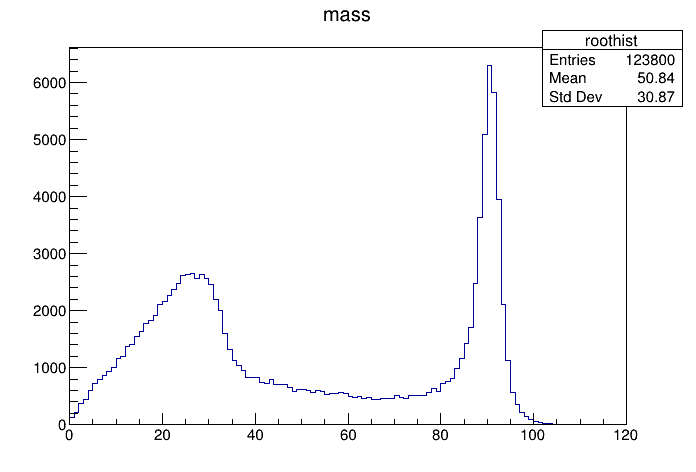

In [4]:
roothist.Draw()
canvas.Draw()

<br><br><br><br><br>

## Z peak in C++ ROOT

It works, but 20 seconds is a long time to wait for 1/8 million dimuons.

The traditional way to speed things up is to translate it into C++.

In [5]:
ROOT.gInterpreter.Declare('''
void compute(TH1D& roothist, TTree& roottree) {
    UInt_t nMuon;
    float Muon_pt[50];
    float Muon_eta[50];
    float Muon_phi[50];
    int32_t Muon_charge[50];

    roottree.SetBranchStatus("*", 0);
    roottree.SetBranchStatus("nMuon", 1);
    roottree.SetBranchStatus("Muon_pt", 1);
    roottree.SetBranchStatus("Muon_eta", 1);
    roottree.SetBranchStatus("Muon_phi", 1);
    roottree.SetBranchStatus("Muon_charge", 1);

    roottree.SetBranchAddress("nMuon", &nMuon);
    roottree.SetBranchAddress("Muon_pt", Muon_pt);
    roottree.SetBranchAddress("Muon_eta", Muon_eta);
    roottree.SetBranchAddress("Muon_phi", Muon_phi);
    roottree.SetBranchAddress("Muon_charge", Muon_charge);

    for (int index = 0; index < 100000; index++) {
        roottree.GetEntry(index);
        if (nMuon >= 2 && Muon_charge[0] + Muon_charge[1] == 0) {
            float mu1_pt = Muon_pt[0];
            float mu2_pt = Muon_pt[1];
            float mu1_eta = Muon_eta[0];
            float mu2_eta = Muon_eta[1];
            float mu1_phi = Muon_phi[0];
            float mu2_phi = Muon_phi[1];
            roothist.Fill(
                sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)))
            );
        }
    }
}
''')

True

ROOT lets you compile a C++ function and run it through PyROOT.

The important thing here is that the _loop over events_ is in the compiled code.

In [6]:
starttime = time.time()

roothist2 = ROOT.TH1D("roothist2", "mass", 120, 0, 120)

ROOT.compute(roothist2, roottree)

cpproot_time = time.time() - starttime
print(f"total time: {cpproot_time} sec")

total time: 0.03395485877990723 sec


In [7]:
pyroot_time / cpproot_time

582.8227529016901

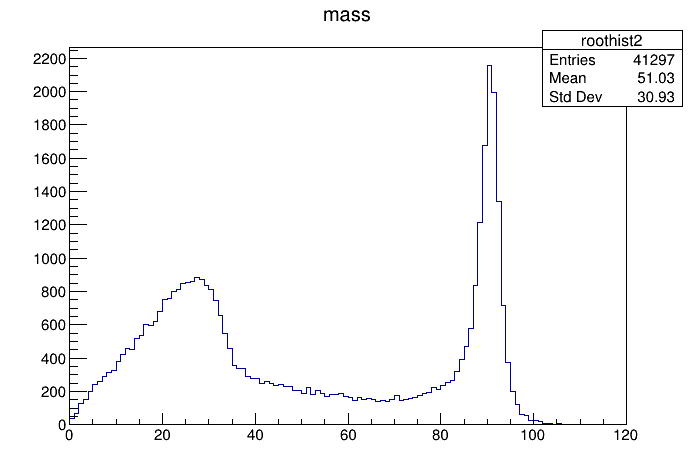

In [8]:
roothist2.Draw()
canvas.Draw()

<br><br><br><br><br>

## Z peak in RDataFrame

RDataFrame is the modern way to build workflows over HEP data in ROOT.

Each node in this pipeline is compiled in C++. The pipeline itself can be built in Python.

<img src="img/rdataframe-flow.svg" style="width: 800px">

In [9]:
df = ROOT.RDataFrame("Events", "data/HiggsZZ4mu.root")

# Each node is connected to the previous, in a chain (which can split and recombine).
df_2mu = df.Filter("nMuon >= 2")
df_os = df_2mu.Filter("Muon_charge[0] + Muon_charge[1] == 0")

# This node is a big C++ block.
df_mass = df_os.Define("Dimuon_mass", '''
float mu1_pt = Muon_pt[0];
float mu2_pt = Muon_pt[1];
float mu1_eta = Muon_eta[0];
float mu2_eta = Muon_eta[1];
float mu1_phi = Muon_phi[0];
float mu2_phi = Muon_phi[1];
return sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)));
''')

roothist3 = df_mass.Histo1D(("h3", "mass", 120, 0, 120), "Dimuon_mass")

The calculation doesn't actually start until you attempt to look at a result (convert to NumPy or draw a plot).

In [10]:
starttime = time.time()

# This one is an endpoint (action).
array = df_mass.AsNumpy(["Dimuon_mass"])

rdfroot_time = time.time() - starttime
print(f"total time: {rdfroot_time} sec")

total time: 1.8850862979888916 sec


In [11]:
pyroot_time / rdfroot_time

10.498015019050479

In [12]:
array

{'Dimuon_mass': ndarray([36.91503 , 88.4434  , 22.870972, ..., 26.973433, 68.36317 ,
          68.305984], dtype=float32)}

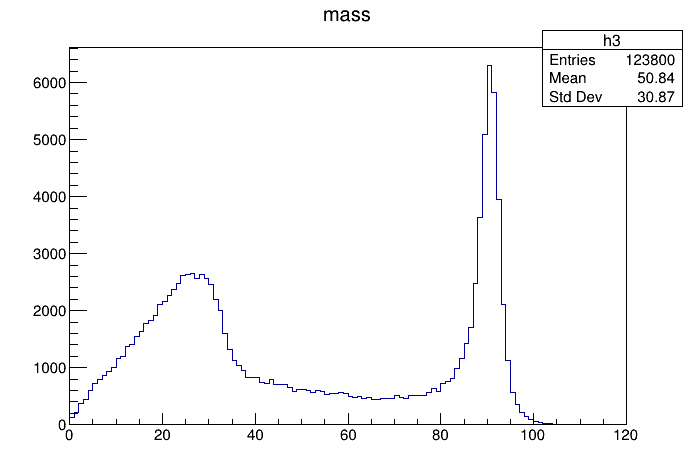

In [13]:
roothist3.Draw()
canvas.Draw()

<br><br><br><br><br>

## Uproot and Awkward Array

Uproot's approach is different: each Python command operates on a whole array at a time (like NumPy).

Loops over all events happen in compiled code, but you don't write that code—you combine primitives to build a workflow.

In [14]:
import awkward as ak
import uproot
import hist

Open a file and look at its contents.

In [15]:
events = uproot.open("data/HiggsZZ4mu.root:Events")
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
MET_pt               | float                    | AsDtype('>f4')
MET_phi              | float                    | AsDtype('>f4')
nGenPart             | uint32_t                 | AsDtype('>u4')
GenPart_

Extract some branches as an "array of records" (renaming the fields).

In [16]:
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"}
)
muons

<Array [{pt: [], eta: [], ... -1, 1, -1]}] type='299683 * {"pt": var * float32, ...'>

In [17]:
muons.fields

['pt', 'eta', 'phi', 'charge']

A cut is an array of booleans, which we can construct as a formula.

In [18]:
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
cut

<Array [False, True, False, ... True, True] type='299683 * bool'>

Applying a cut is a slice. In the same slice, we can pick the first (`0`) and second (`1`) muon in each event.

In [19]:
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
mu1, mu2

(<Array [{pt: 18.6, eta: -0.179, ... charge: 1}] type='123800 * {"pt": float32, "...'>,
 <Array [{pt: 23.6, eta: 0.224, ... charge: -1}] type='123800 * {"pt": float32, "...'>)

Let's use the [hist](https://github.com/scikit-hep/hist#readme) library for histograms.

In [20]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double())

In [21]:
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 123753.0 (123800.0 with flow)

And Matplotlib for plots.

In [22]:
import matplotlib.pyplot as plt

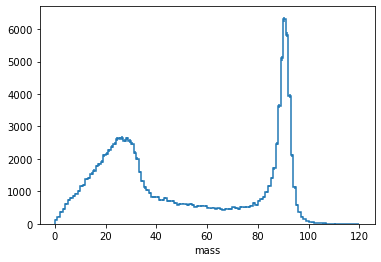

In [23]:
h.plot();

<br><br><br><br><br>

Now let's do the whole thing in one cell and time it.

In [24]:
starttime = time.time()

# read data
muons = events.arrays(
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},
    array_cache=None,   # no cheating!
)

# compute
cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
mu1 = muons[cut, 0]
mu2 = muons[cut, 1]
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

uproot_time = time.time() - starttime
print(f"total time: {uproot_time} sec")

total time: 0.06754660606384277 sec


In [25]:
pyroot_time / uproot_time

292.97792178912925

It's in the same ballpark as C++. It can be 1.5× to 2× slower, but it's much closer to C++ on a log plot than it is to Python "for" loops.

<br><br><br><br><br>

## The Pythonic HEP ecosystem

Uproot is not a framework, it _only_ does ROOT I/O. Awkward Array handles array manipulation, hist does histograms, etc.

It is part of this complete breakfast:

<img src="img/logo-parade.svg" width="800px">

<br><br><br><br><br>

## Uproot

Uproot is an independent implementation of ROOT I/O that leverages standard Python libraries.

<img src="img/abstraction-layers.svg" width="800px">

<br><br><br><br><br>

The documentation is on [https://uproot.readthedocs.io/](https://uproot.readthedocs.io/).

<img src="img/uproot-documentation.png" width="800px"/>

<br><br><br><br><br>

## Navigating a ROOT file

<img src="img/terminology.svg" style="width: 800px">

In [27]:
histograms = uproot.open("data/HiggsZZ4mu_histograms.root")
histograms

<ReadOnlyDirectory '/' at 0x7f76cda01c10>

In [28]:
histograms.file

<ReadOnlyFile 'data/HiggsZZ4mu_histograms.root' at 0x7f76cc0bfd90>

In Uproot, a directory is a dict-like object with subscripting (square brackets), [keys](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#values), [items](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#items), and [classnames](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#classnames) methods.

In [30]:
histograms["Z"]

<ReadOnlyDirectory '/Z' at 0x7f76cc0859a0>

In [31]:
histograms["Z"]["4mu"]

<ReadOnlyDirectory '/Z/4mu' at 0x7f76cda01a90>

Try `recursive`, `filter_name`, and `filter_classname` arguments.

In [29]:
histograms.keys()

['num;1',
 'num/NGMuons;1',
 'num/NMuons;1',
 'num/Nelectrons;1',
 'num/NGoodGMuons;1',
 'num/NGoodRecMuons;1',
 'num/NGoodElectron;1',
 'Z;1',
 'Z/all;1',
 'Z/all/GMmass;1',
 'Z/all/GMmass_extended;1',
 'Z/all/GMmass_extended_600;1',
 'Z/all/massZto2muon;1',
 'Z/all/massZto2e;1',
 'Z/4mu;1',
 'Z/4mu/by_pt;1',
 'Z/4mu/by_pt/mZ12_4mu;1',
 'Z/4mu/by_pt/mZ34_4mu;1',
 'Z/4mu/by_pt/mZ13_4mu;1',
 'Z/4mu/by_pt/mZ24_4mu;1',
 'Z/4mu/by_pt/mZ14_4mu;1',
 'Z/4mu/by_pt/mZ23_4mu;1',
 'Z/4mu/by_mass;1',
 'Z/4mu/by_mass/mZa_4mu;1',
 'Z/4mu/by_mass/mZb_4mu;1',
 'Z/4e;1',
 'Z/4e/by_pt;1',
 'Z/4e/by_pt/mZ12_4e;1',
 'Z/4e/by_pt/mZ34_4e;1',
 'Z/4e/by_pt/mZ13_4e;1',
 'Z/4e/by_pt/mZ24_4e;1',
 'Z/4e/by_pt/mZ14_4e;1',
 'Z/4e/by_pt/mZ23_4e;1',
 'Z/4e/by_mass;1',
 'Z/4e/by_mass/mZa_4e;1',
 'Z/4e/by_mass/mZb_4e;1',
 'Z/2mu2e;1',
 'Z/2mu2e/massZmu_2mu2e;1',
 'Z/2mu2e/massZe_2mu2e;1',
 'H;1',
 'H/4mu;1',
 'H/4mu/mass4mu_7TeV;1',
 'H/4mu/mass4mu_8TeV;1',
 'H/4mu/mass4mu_8TeV_low;1',
 'H/4mu/mass4mu_full;1',
 'H/4e;1

Most histograms and graphs can be converted to types in other Python libraries.

Try the `to_hist()` method on this one.

In [33]:
histograms["Z/all/massZto2muon"]

<TH1D (version 3) at 0x7f76b926de20>

<br><br><br>

**Three-minute exercise:** find the 2D histogram and plot it.

In [34]:
histograms

<ReadOnlyDirectory '/' at 0x7f76cda01c10>

<br><br><br><br><br>

## Can Uproot read my data?

In [ ]:
icecube = uproot.open("data/icecube-supernovae.root")
icecube.keys()

In [ ]:
icecube.classname_of("config/detector")

In [ ]:
icecube.file.show_streamers("I3Eval_t")

In [ ]:
icecube["config/detector"]

In [ ]:
icecube["config/detector"].all_members

In [ ]:
icecube["config/detector"].member("ChannelIDMap")

In [ ]:
zmumu_file = uproot.open("data/Zmumu.root")
zmumu_file.keys()

In [ ]:
zmumu = zmumu_file["events"]
zmumu.show()

In [ ]:
zmumu.keys()

In [ ]:
zmumu.keys(filter_typename="/int.*/")

In [ ]:
zmumu.typenames()

In [ ]:
{name: branch.interpretation for name, branch in zmumu.items()}

In [ ]:
zmumu["M"].array()

Some important parameters:

   * `entry_start`, `entry_stop` to limit how much you read (if it's big)
   * `library="np"` for NumPy arrays, `library="ak"` for Awkward Arrays, and `library="pd"` for Pandas (Series or DataFrame)

In [ ]:
zmumu["M"].array(entry_stop=5)

In [ ]:
zmumu["M"].array(library="np")

In [ ]:
zmumu["M"].array(library="ak")   # default

In [ ]:
zmumu["M"].array(library="pd")

In [ ]:
zmumu.arrays()

In [ ]:
zmumu.arrays(library="np")

In [ ]:
zmumu.arrays(library="pd")

In [ ]:
zmumu.arrays(["px1", "py1", "px2", "py2"], library="pd")

Or it can be computed expressions.

In [ ]:
zmumu.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

This is to support any [aliases](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#aliases) that might be in the [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html), but you can make up your own `aliases` on the spot.

In [ ]:
zmumu.arrays(["pt1", "pt2"], {"pt1": "sqrt(px1**2 + py1**2)", "pt2": "sqrt(px2**2 + py2**2)"}, library="pd")

The `expressions` parameter is not a good way to select branches by name.

   * nested branches, paths with "`/`", _would be interpreted as division!_
   * wildcards, paths with "`*`", _would be interpreted as multiplication!_

To select branches by name, use `filter_name`, `filter_typename`, `filter_branch` (all in the [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) documentation).

In [ ]:
zmumu.arrays(filter_name="p[xyz]*", library="pd")

(These filters have the same meaning as in [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#keys) and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#typenames), but those methods do not read potentially large datasets.)

In [ ]:
zmumu.keys(filter_name="p[xyz]*")

In [ ]:
zmumu.typenames(filter_name="p[xyz]*")

<br><br><br>

### Get arrays in manageable chunks

The [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#iterate) method is like [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays), but it can be used in a loop over chunks of the array.

How large are the chunks? You should set that with `step_size`.

In [ ]:
for arrays in zmumu.iterate(step_size=300):
    print(repr(arrays))

In [ ]:
for arrays in zmumu.iterate(step_size="50 kB"):   # 50 kB is very small! for illustrative purposes only!
    print(repr(arrays))

<br><br><br>

### Collections of files (like TChain)

If you want to read a bunch of files in one call, it has to be a function, rather than a method of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html).

   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

In [ ]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.pylab

In [ ]:
h = hist.Hist.new.Reg(100, 0, 500, name="mass").Double()

for muons in uproot.iterate(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],

    # expressions
    ["pt", "eta", "phi", "charge"],
    aliases={"pt": "Muon_pt", "eta": "Muon_eta", "phi": "Muon_phi", "charge": "Muon_charge"},    

    # the all-important step_size!
    step_size="1 MB",
):
    # do everything you're going to do to this array
    cut = (ak.num(muons.charge) >= 2) & (ak.sum(muons.charge[:, :2], axis=1) == 0)
    mu1 = muons[cut, 0]
    mu2 = muons[cut, 1]

    # such as filling a histogram
    h.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

    h.plot()
    plt.yscale("log")
    IPython.display.display(matplotlib.pylab.gcf())
    IPython.display.clear_output(wait=True)

    if h.counts().sum() > 300000:
        break

In [ ]:
lazy = uproot.lazy(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],
    # step_size is still important
    step_size="1 MB",
)
lazy

In [ ]:
lazy.Muon_pt

In [ ]:
lazy.Muon_eta

In [ ]:
events = uproot.open("data/HiggsZZ4mu.root:Events")

In [ ]:
nonjagged = events["MET_pt"].array(entry_stop=20, library="np")
nonjagged

In [ ]:
nonjagged[:5]

In [ ]:
jagged_awkward = events["Muon_pt"].array(entry_stop=20)
jagged_awkward

In [ ]:
jagged_awkward.tolist()

In [ ]:
jagged_numpy = events["Muon_pt"].array(entry_stop=20, library="np")
jagged_numpy

In [ ]:
jagged_awkward[:, :1]

In [ ]:
jagged_numpy[:, :1]

In [ ]:
np.array([x[:1] for x in jagged_numpy])

In [ ]:
events.arrays(filter_name=["Muon_*"], library="pd")

In [ ]:
array = ak.from_parquet("data/HiggsZZ4mu.parquet")
array

In [ ]:
array.fields

In [ ]:
array[0].tolist()

In [ ]:
array.muons.pt

In [ ]:
nanoaod_style = events.arrays(filter_name="Muon_*")
nanoaod_style.type

In [ ]:
array.muons.type

In [ ]:
nanoevents_style = ak.zip({
    "pt": nanoaod_style.Muon_pt,
    "eta": nanoaod_style.Muon_eta,
    "phi": nanoaod_style.Muon_phi,
    "mass": nanoaod_style.Muon_mass,
    "charge": nanoaod_style.Muon_charge,
})
nanoevents_style.type

In [ ]:
array.luminosityBlock

In [ ]:
lumilengths = ak.run_lengths(array.luminosityBlock)
lumilengths

In [ ]:
array_by_lumi = ak.unflatten(array, lumilengths, axis=0)
array_by_lumi

In [ ]:
array_by_lumi.luminosityBlock[0]

In [ ]:
array.type

In [ ]:
array_by_lumi.type

In [ ]:
ak.sum(array_by_lumi.muons.pt, axis=-1)

<img src="img/example-reduction.svg" style="width: 800px">

In [ ]:
array.muons

In [ ]:
cut = ak.num(array.muons) >= 2
cut

In [ ]:
array.muons[cut]

In [ ]:
array.muons.mask[cut]

In [ ]:
selected_muons = array.muons[cut]

selected_muons.charge[:, 0] + selected_muons.charge[:, 1] == 0

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="img/cartoon-cartesian.svg"></td><td><img src="img/cartoon-combinations.svg"></td></tr>
</table>

In [ ]:
ak.combinations(array.muons, 2).type

In [ ]:
mu1, mu2 = ak.unzip(ak.combinations(array.muons, 2))
mu1, mu2

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten(
    np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi)))
))

In [ ]:
import vector
vector.register_awkward()

In [ ]:
muons = ak.with_name(array.muons, "Momentum4D")
muons

In [ ]:
mu1, mu2 = ak.unzip(ak.combinations(muons, 2))
mu1, mu2

In [ ]:
(mu1 + mu2).mass

In [ ]:
h = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()
h.fill(ak.flatten((mu1 + mu2).mass))

In [ ]:
gen = ak.with_name(array.gen, "Momentum3D")
gen

In [ ]:
gen.fields

In [ ]:
reco_gen = ak.cartesian({"muon": muons, "gen": gen}, nested=True)
reco_gen

In [ ]:
mu, g = ak.unzip(reco_gen)
mu, g

In [ ]:
mu.deltaR(g)

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g), axis=None)
)

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(mu.deltaR(g)[abs(g.pdgId) == 13], axis=None)
)

In [ ]:
hist.Hist.new.Reg(100, 0, 5).Double().fill(
    ak.flatten(ak.min(mu.deltaR(g), axis=-1), axis=None)
)

In [ ]:
best = ak.argmin(mu.deltaR(g), axis=-1, keepdims=True)
best

In [ ]:
reco_gen[best]

In [ ]:
ak.flatten(reco_gen[best], axis=-1)[:4].tolist()

In [ ]:
import numba as nb

In [ ]:
starttime = time.time()

sumpt = np.zeros(len(array), np.float64)
for i, event in enumerate(array):
    for muon in event.muons:
        sumpt[i] += muon.pt

python_time = time.time() - starttime
print(f"total time: {python_time} sec")

In [ ]:
@nb.jit
def calculate_sumpt(array):
    out = np.zeros(len(array), np.float64)
    for i, event in enumerate(array):
        for muon in event.muons:
            out[i] += muon.pt
    return out

In [ ]:
calculate_sumpt(array)

In [ ]:
starttime = time.time()

sumpt = calculate_sumpt(array)

numba_time = time.time() - starttime
print(f"total time: {numba_time} sec")

In [ ]:
python_time / numba_time

In [ ]:
starttime = time.time()

sumpt = ak.sum(array, axis=-1)

awkward_time = time.time() - starttime
print(f"total time: {awkward_time} sec")

In [ ]:
python_time / awkward_time

In [ ]:
@nb.jit
def build_nested(array, builder):
    for event in array:
        builder.begin_list()
        
        for muon in event.muons:
            builder.append(muon.pt)
        
        builder.end_list()
    
    return builder

build_nested(array, ak.ArrayBuilder()).snapshot()

In [ ]:
array.muons.pt

In [ ]:
@nb.jit
def matching(array_muons, array_gen, builder):
    for muons_event, gen_event in zip(array_muons, array_gen):
        builder.begin_list()

        for muon in muons_event:
            best_i = -1
            best_dr = -1.0
            for i, gen in enumerate(gen_event):
                dr = muon.deltaR(gen)
                if best_i < 0 or dr < best_dr:
                    best_i = i
                    best_dr = dr

            if best_i < 0:
                builder.append(None)
            else:
                builder.append(best_i)

        builder.end_list()

    return builder

index_of_best = matching(muons, gen, ak.ArrayBuilder()).snapshot()
index_of_best

In [ ]:
gen_match = gen[index_of_best]
gen_match

In [ ]:
ak.num(gen), ak.num(muons), ak.num(gen_match)

In [ ]:
ak.zip({"muons": muons, "gen": gen_match})

In [ ]:
four_muons = muons[(ak.num(muons) == 4) & (ak.sum(muons.charge, axis=-1) == 0)]
four_muons

In [ ]:
mu_plus = four_muons[four_muons.charge > 0]
mu_minus = four_muons[four_muons.charge < 0]
mu_plus, mu_minus

In [ ]:
ak.num(mu_plus), ak.num(mu_minus)

In [ ]:
mu_plus_0 = mu_plus[:, 0]
mu_plus_1 = mu_plus[:, 1]
mu_minus_0 = mu_minus[:, 0]
mu_minus_1 = mu_minus[:, 1]

mu_plus_0, mu_plus_1, mu_minus_0, mu_minus_1

In [ ]:
z00 = mu_plus_0 + mu_minus_0
z11 = mu_plus_1 + mu_minus_1

z01 = mu_plus_0 + mu_minus_1
z10 = mu_plus_1 + mu_minus_0

In [ ]:
import particle

In [ ]:
particle.Particle.from_string("Z0")

In [ ]:
particle.Particle.from_string("Z0").mass

In [ ]:
zGeV = particle.Particle.from_string("Z0").mass / 1000

In [ ]:
np.minimum(np.array([1, 2, 3]), np.array([3, 2, 1]))

In [ ]:
zdist_0011 = np.minimum(abs(z00.mass - zGeV), abs(z11.mass - zGeV))
zdist_0110 = np.minimum(abs(z01.mass - zGeV), abs(z10.mass - zGeV))
zdist_0011, zdist_0110

In [ ]:
is_0011 = zdist_0011 < zdist_0110
is_0011

In [ ]:
z0011_pair = ak.concatenate((z00[:, np.newaxis], z11[:, np.newaxis]), axis=1)
z0110_pair = ak.concatenate((z01[:, np.newaxis], z10[:, np.newaxis]), axis=1)
z0011_pair, z0110_pair

In [ ]:
ak.num(z0011_pair), ak.num(z0110_pair)

In [ ]:
correct_pair = ak.where(is_0011, z0011_pair, z0110_pair)
correct_pair

In [ ]:
ak.num(correct_pair)

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    correct_pair[:, 0].mass
)

In [ ]:
sort_index = ak.argsort(correct_pair.mass)
sort_index

In [ ]:
sorted_pair = correct_pair[sort_index]
sorted_pair

In [ ]:
hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    sorted_pair[:, 0].mass
)

In [ ]:
hist.Hist.new.Reg(150, 0, 150, name="mass").Double().fill(
    (sorted_pair[:, 0] + sorted_pair[:, 1]).mass
)